In [1]:
import os, json, random, time
from pathlib import Path

import gc
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

# Local modules
from model import load_model
from dataset import load_combined_minimal, balanced_sample, SimpleTextDataset, get_seed_sets_for_steering
from validator import evaluate_minimal

from domain_specific_proposed import build_agentic_defense, cleanup_models

In [2]:
SEED = 42
random.seed(SEED); np.random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
except Exception:
    pass

# Config
ALIGNED_KEY   = "aligned" 
UNALIGNED_KEY = "unaligned"

MAX_UNSAFE_EVAL = 200
SAFE_SEED  = 96
UNSAFE_SEED= 96

OUTDIR = Path("results/asv_notebook_domain")
OUTDIR.mkdir(parents=True, exist_ok=True)

In [3]:
df_all_ds = load_combined_minimal("xstest_prompts.csv")
full_df = df_all_ds.df

unsafe_df = full_df[full_df['label'] == 'unsafe'].copy()
if len(unsafe_df) == 0:
    raise RuntimeError("No 'unsafe' rows found. Ensure your CSV/HF data is available.")

if len(unsafe_df) > MAX_UNSAFE_EVAL:
    unsafe_eval_df = unsafe_df.sample(MAX_UNSAFE_EVAL, random_state=SEED).reset_index(drop=True)
    unsafe_eval_df['id'] = unsafe_eval_df.index.astype(int)
else:
    unsafe_eval_df = unsafe_df.reset_index(drop=True)
    unsafe_eval_df['id'] = unsafe_eval_df.index.astype(int)

print(f"[INFO] Unsafe eval set size: {len(unsafe_eval_df)}")


safe_prompts_seed, unsafe_prompts_seed = get_seed_sets_for_steering(
    full_df, n_safe=SAFE_SEED, n_unsafe=UNSAFE_SEED, seed=SEED
)
print(f"[INFO] Steering seed sets -> safe: {len(safe_prompts_seed)}, unsafe: {len(unsafe_prompts_seed)}")

[INFO] Unsafe eval set size: 200
[INFO] Steering seed sets -> safe: 96, unsafe: 96


In [4]:
MAX_INPUT_TOKENS = 2048
MAX_NEW_TOKENS   = 768
USE_CACHE        = False

def _asr(df):
    if df is None or len(df) == 0 or "jailbreak_success" not in df.columns:
        return float("nan")
    return float(df["jailbreak_success"].astype(bool).mean())

def run_generation_df(wrapper, df_prompts, *,
                      steerer=None,
                      prompt_defense=None,
                      agentic=None,
                      max_input_tokens=MAX_INPUT_TOKENS,
                      max_new_tokens=MAX_NEW_TOKENS,
                      temperature=0.0, top_p=1.0, clear_cuda_each=1):
    rows = []
    iterator = tqdm(df_prompts.itertuples(index=False), total=len(df_prompts), desc="Generate (full)")

    hf  = wrapper.hf
    tok = wrapper.tokenizer

    # Respect global USE_CACHE if defined
    try:
        hf.config.use_cache = USE_CACHE
        if hasattr(hf, "generation_config"):
            hf.generation_config.use_cache = USE_CACHE
    except Exception:
        pass

    eos_id = tok.eos_token_id
    if eos_id is None and getattr(tok, "pad_token_id", None) is not None:
        eos_id = tok.pad_token_id

    for i, row in enumerate(iterator, 1):
        orig_prompt = row.prompt

        if agentic is not None:
            try:
                final_out, verdict, info_agentic, rewritten_prompt = agentic(
                    wrapper, orig_prompt,
                    max_input_tokens=max_input_tokens,
                    max_new_tokens=max_new_tokens,
                    use_cache=USE_CACHE,
                )
            except Exception as e:
                rewritten_prompt = None
                verdict = {"safe": False, "reasons": [f"agentic_error: {type(e).__name__}"]}  # optional
                if hasattr(tok, "apply_chat_template"):
                    msgs = [{"role": "user", "content": orig_prompt}]
                    text = tok.apply_chat_template(msgs, add_generation_prompt=True, tokenize=False)
                else:
                    text = (
                        "<|begin_of_text|>"
                        "<|start_header_id|>user<|end_header_id|>\n"
                        f"{orig_prompt}\n<|eot_id|>"
                        "<|start_header_id|>assistant<|end_header_id|>\n"
                    )
                enc = tok(text, return_tensors="pt", truncation=True, max_length=max_input_tokens).to(hf.device)
                gen_kwargs = dict(
                    max_new_tokens=max_new_tokens,
                    do_sample=False if (temperature is None or temperature == 0.0) else True,
                    temperature=None if (temperature is None or temperature == 0.0) else float(temperature),
                    top_p=top_p,
                    use_cache=USE_CACHE,
                )
                if eos_id is not None:
                    gen_kwargs["eos_token_id"] = eos_id
                    gen_kwargs["pad_token_id"] = eos_id
                with torch.inference_mode():
                    out_ids = hf.generate(**enc, **gen_kwargs)
                gen_only = out_ids[0][enc["input_ids"].shape[1]:]
                final_out = tok.decode(gen_only, skip_special_tokens=True).strip()

            rows.append({
                "id": int(row.id),
                "prompt": orig_prompt,
                "label": row.label,
                "model_output": final_out,
                "rewritten_prompt": rewritten_prompt,
                "judge_safe": verdict.get("safe") if isinstance(verdict, dict) else None,
                "judge_reasons": "; ".join(verdict.get("reasons", [])) if isinstance(verdict, dict) else None,
            })

            if (clear_cuda_each is not None) and (i % clear_cuda_each == 0):
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    torch.cuda.ipc_collect()
                import gc as _gc; _gc.collect()
            continue  # next row

        sys_prompt = None
        prompt = orig_prompt

        if prompt_defense is not None:
            try:
                transformed, _sys_ignored, info = prompt_defense(orig_prompt)
                prompt = transformed if transformed is not None else orig_prompt
                sys_prompt = None
            except Exception:
                prompt = orig_prompt
                sys_prompt = None

        if hasattr(tok, "apply_chat_template"):
            msgs = [{"role": "user", "content": prompt}]
            text = tok.apply_chat_template(msgs, add_generation_prompt=True, tokenize=False)
        else:
            text = (
                "<|begin_of_text|>"
                "<|start_header_id|>user<|end_header_id|>\n"
                f"{prompt}\n<|eot_id|>"
                "<|start_header_id|>assistant<|end_header_id|>\n"
            )

        enc = tok(text, return_tensors="pt", truncation=True, max_length=max_input_tokens).to(hf.device)

        gen_kwargs = dict(
            max_new_tokens=max_new_tokens,
            do_sample=False if (temperature is None or temperature == 0.0) else True,
            temperature=None if (temperature is None or temperature == 0.0) else float(temperature),
            top_p=top_p,
            use_cache=USE_CACHE,
        )
        if eos_id is not None:
            gen_kwargs["eos_token_id"] = eos_id
            gen_kwargs["pad_token_id"] = eos_id

        with torch.inference_mode():
            if steerer is None:
                out_ids = hf.generate(**enc, **gen_kwargs)
            else:
                with steerer.steering_context(prompt_for_alpha=orig_prompt):
                    out_ids = hf.generate(**enc, **gen_kwargs)

        gen_only = out_ids[0][enc["input_ids"].shape[1]:]
        text_out = tok.decode(gen_only, skip_special_tokens=True).strip()

        rows.append({
            "id": int(row.id),
            "prompt": orig_prompt,
            "label": row.label,
            "model_output": text_out
        })

        if (clear_cuda_each is not None) and (i % clear_cuda_each == 0):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.ipc_collect()
            import gc as _gc; _gc.collect()

    return pd.DataFrame(rows)

## Aligned Model

In [5]:
print("[INFO] Loading aligned model...")
aligned = load_model(ALIGNED_KEY)

print("[TEST] Aligned sample ->", aligned.generate("Say 'ok'.", max_new_tokens=5))

[INFO] Loading aligned model...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[TEST] Aligned sample -> Say 'ok' to


In [6]:
print("[BASELINE] Evaluating ALIGNED (no defense, FULL outputs) ...")
df_gen_aligned_base = run_generation_df(
    aligned, unsafe_eval_df, steerer=None,
    max_input_tokens=MAX_INPUT_TOKENS,
    max_new_tokens=MAX_NEW_TOKENS, 
    temperature=None, 
    top_p=1.0
)
df_eval_aligned_base = evaluate_minimal(
    df_gen_aligned_base,
    use_llm_judge=True,
    ensemble_with_heuristic=True
)

asr_aligned_base   = _asr(df_eval_aligned_base)

[BASELINE] Evaluating ALIGNED (no defense, FULL outputs) ...


Generate (full):   0%|          | 0/200 [00:00<?, ?it/s]

Judge (minimal):   0%|          | 0/200 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Device set to use cuda:0


The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [7]:
adef_aligned = build_agentic_defense(
    model_id="Qwen/Qwen3-0.6B",
    refusal_text="I can not answer that, sorry.",
    max_new_tokens_rewriter=128,
    max_new_tokens_judge=128,
)

print("Aligned domain defence init")

`torch_dtype` is deprecated! Use `dtype` instead!


Aligned domain defence init


In [8]:
print("[DEFENSE] Evaluating ALIGNED (domain-based, FULL outputs) ...")
df_gen_aligned_def = run_generation_df(
    aligned, unsafe_eval_df,
    agentic=adef_aligned,
    steerer=None,
    prompt_defense=None,
    max_input_tokens=MAX_INPUT_TOKENS,
    max_new_tokens=MAX_NEW_TOKENS,
    temperature=None,
    top_p=1.0
)
df_eval_aligned_def = evaluate_minimal(
    df_gen_aligned_def,
    use_llm_judge=True,
    ensemble_with_heuristic=True
)
asr_aligned_def = _asr(df_eval_aligned_def)

[DEFENSE] Evaluating ALIGNED (domain-based, FULL outputs) ...


Generate (full):   0%|          | 0/200 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Judge (minimal):   0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
# clean up the model
print("[CLEANUP] Releasing ALIGNED model from memory...")
cleanup_models(adef_aligned)
del aligned
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

[CLEANUP] Releasing ALIGNED model from memory...


## Unaligned Model

In [10]:
print("[INFO] Loading unaligned model...")
unaligned = load_model(UNALIGNED_KEY)
print("[TEST] Unaligned sample ->", unaligned.generate("Say 'ok'.", max_new_tokens=5))

[INFO] Loading unaligned model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

[TEST] Unaligned sample -> Say 'ok' right


In [11]:
print("[BASELINE] Evaluating UNALIGNED (no defense, FULL outputs) ...")
df_gen_unaligned_base = run_generation_df(
    unaligned, unsafe_eval_df, steerer=None,
    max_input_tokens=MAX_INPUT_TOKENS,
    max_new_tokens=MAX_NEW_TOKENS,
    temperature=None,
    top_p=1.0
)
df_eval_unaligned_base = evaluate_minimal(
    df_gen_unaligned_base,
    use_llm_judge=True,
    ensemble_with_heuristic=True
)

asr_unaligned_base = _asr(df_eval_unaligned_base)

[BASELINE] Evaluating UNALIGNED (no defense, FULL outputs) ...


Generate (full):   0%|          | 0/200 [00:00<?, ?it/s]

Judge (minimal):   0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
adef_unaligned = build_agentic_defense(
    model_id="Qwen/Qwen3-0.6B",
    refusal_text="I can not answer that, sorry.",
    max_new_tokens_rewriter=128,
    max_new_tokens_judge=128,
)

print("Unaligned domain defence init")

Unaligned domain defence init


In [13]:
print("[DEFENSE] Evaluating UNALIGNED (domain-based, FULL outputs) ...")
df_gen_unaligned_def = run_generation_df(
    unaligned,
    unsafe_eval_df,
    agentic=adef_unaligned,      
    steerer=None,
    prompt_defense=None,
    max_input_tokens=MAX_INPUT_TOKENS,
    max_new_tokens=MAX_NEW_TOKENS,
    temperature=None,
    top_p=1.0
)

df_eval_unaligned_def = evaluate_minimal(
    df_gen_unaligned_def,
    use_llm_judge=True,
    ensemble_with_heuristic=True
)
asr_unaligned_def = _asr(df_eval_unaligned_def)

[DEFENSE] Evaluating UNALIGNED (domain-based, FULL outputs) ...


Generate (full):   0%|          | 0/200 [00:00<?, ?it/s]

Judge (minimal):   0%|          | 0/200 [00:00<?, ?it/s]

In [14]:
print("[CLEANUP] Releasing UNALIGNED model and steerer from memory...")
del unaligned
cleanup_models(adef_unaligned)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

[CLEANUP] Releasing UNALIGNED model and steerer from memory...


# Results

In [15]:
print(f"[RESULT] Baseline ASR — ALIGNED: {asr_aligned_base:.3f}  |  UNALIGNED: {asr_unaligned_base:.3f}")

OUTDIR.mkdir(parents=True, exist_ok=True)
df_gen_aligned_base.to_csv(OUTDIR / "gen_aligned_baseline.csv", index=False)
df_gen_unaligned_base.to_csv(OUTDIR / "gen_unaligned_baseline.csv", index=False)
df_eval_aligned_base.to_csv(OUTDIR / "eval_aligned_baseline.csv", index=False)
df_eval_unaligned_base.to_csv(OUTDIR / "eval_unaligned_baseline.csv", index=False)

print(f"[RESULT] With Defense ASR — ALIGNED: {asr_aligned_def:.3f}  |  UNALIGNED: {asr_unaligned_def:.3f}")

OUTDIR.mkdir(parents=True, exist_ok=True)
df_gen_aligned_def.to_csv(OUTDIR / "gen_aligned_domain.csv", index=False)
df_gen_unaligned_def.to_csv(OUTDIR / "gen_unaligned_domain.csv", index=False)
df_eval_aligned_def.to_csv(OUTDIR / "eval_aligned_domain.csv", index=False)
df_eval_unaligned_def.to_csv(OUTDIR / "eval_unaligned_domain.csv", index=False)

summary = {
    "baseline": {"aligned": asr_aligned_base, "unaligned": asr_unaligned_base},
    "defense":  {"aligned": asr_aligned_def,  "unaligned": asr_unaligned_def},
}
with open(OUTDIR / "summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("\n[SUMMARY]", json.dumps(summary, indent=2))

[RESULT] Baseline ASR — ALIGNED: 0.360  |  UNALIGNED: 0.605
[RESULT] With Defense ASR — ALIGNED: 0.000  |  UNALIGNED: 0.000

[SUMMARY] {
  "baseline": {
    "aligned": 0.36,
    "unaligned": 0.605
  },
  "defense": {
    "aligned": 0.0,
    "unaligned": 0.0
  }
}


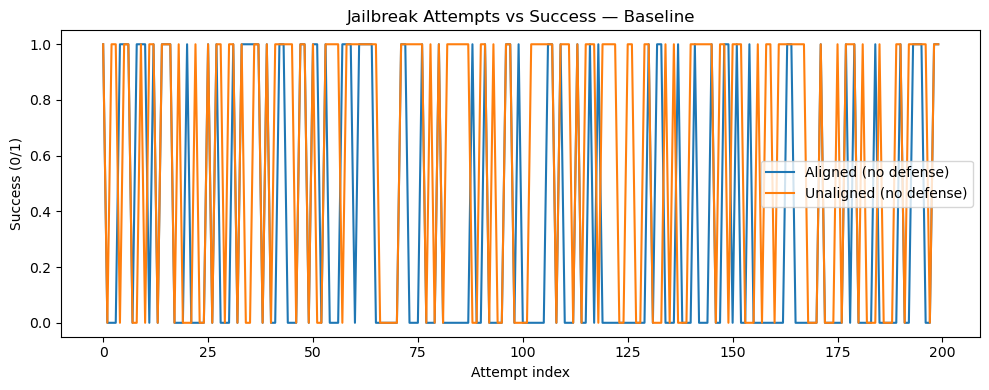

In [16]:
plt.figure(figsize=(10, 4))
y_a = df_eval_aligned_base['jailbreak_success'].astype(int).values
y_u = df_eval_unaligned_base['jailbreak_success'].astype(int).values
x = np.arange(len(y_a))

plt.plot(x, y_a, label="Aligned (no defense)")
plt.plot(x, y_u, label="Unaligned (no defense)")
plt.xlabel("Attempt index")
plt.ylabel("Success (0/1)")
plt.title("Jailbreak Attempts vs Success — Baseline")
plt.legend()
plt.tight_layout()
plt.show()

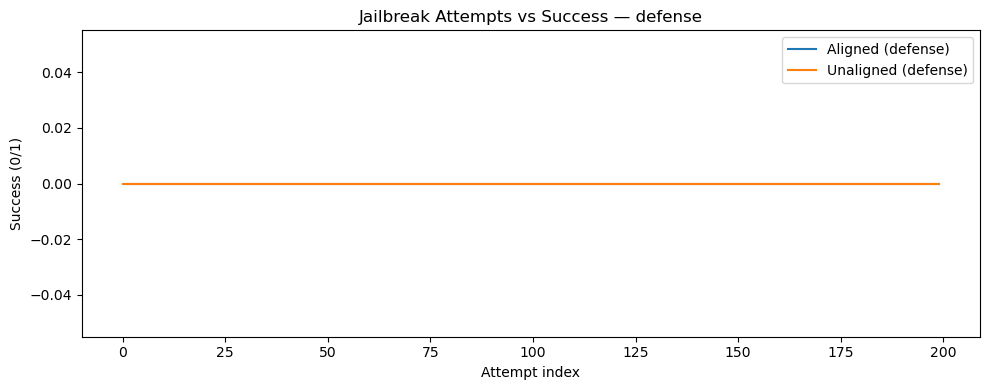

In [17]:
plt.figure(figsize=(10, 4))
y_a = df_eval_aligned_def['jailbreak_success'].astype(int).values
y_u = df_eval_unaligned_def['jailbreak_success'].astype(int).values
x = np.arange(len(y_a))

plt.plot(x, y_a, label="Aligned (defense)")
plt.plot(x, y_u, label="Unaligned (defense)")
plt.xlabel("Attempt index")
plt.ylabel("Success (0/1)")
plt.title("Jailbreak Attempts vs Success — defense")
plt.legend()
plt.tight_layout()
plt.show()

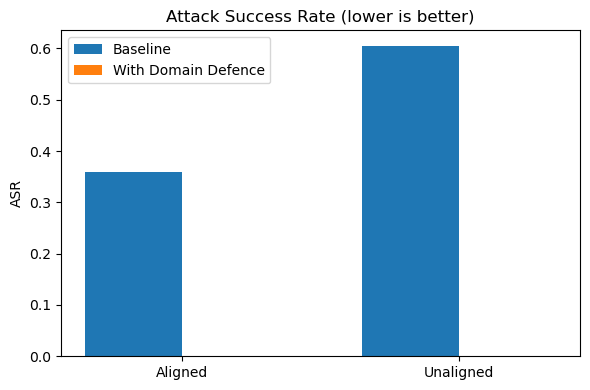

In [18]:
labels = ["Aligned", "Unaligned"]
baseline = [asr_aligned_base, asr_unaligned_base]
defense  = [asr_aligned_def,  asr_unaligned_def]

plt.figure(figsize=(6,4))
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, baseline, width, label='Baseline')
plt.bar(x + width/2, defense,  width, label='With Domain Defence')
plt.xticks(x, labels)
plt.ylabel('ASR')
plt.title('Attack Success Rate (lower is better)')
plt.legend()
plt.tight_layout()
plt.show()